# Q-Learning for Cartpole

### The cartpole environment from OpenAI Gym is a game where the player must keep an inverted pendulum balanced.  At every timestep, the player can move the cart left or right while receiving information about the pendulum and the cart's motion.  Here I use reinforcement learning to teach a deep neural network to balance the cart.  The method is called q-learning.

#### Import the necessary packages

In [7]:
import gym ### cartpole environment
import tensorflow as tf ### to create a neural network
import matplotlib.pyplot as plt
import numpy as np
import random

#### We can run the simulation to see how the pendulum and cart move

In [3]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(100):
    env.render()
    env.step(env.action_space.sample()) # take a random action

You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


#### Define the functions that will build the neural network

In [142]:
### Initialize the input and output vectors
def initialize_placeholders(n_x,n_y):
    
    ### n_x: length of input vector
    ### n_y: length of output vector
    
    X = tf.placeholder(tf.float32,shape = [None,n_x])
    Y = tf.placeholder(tf.float32,shape = [None,n_y])
                
    return X,Y

### Initialize the nodes of the neural network
def initialize_parameters(layer_dims):
    
    ### layer_dims: array of number of nodes in each layer
    ### W_: weights of layer _
    ### B_: biases of layer _
    ### parameters: dictionary of all weights and biases
    
    parameters = {}
    for l in range(len(layer_dims)-1):
        
        W = tf.get_variable("W" + str(l+1),[layer_dims[l],layer_dims[l+1]],initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        B = tf.Variable(tf.zeros([1,layer_dims[l+1]]))
        
        parameters["W" + str(l+1)] = W
        parameters["B" + str(l+1)] = B
        
    
    return parameters

### Forward propagation of input vector through neural network
def forward_propagation(X,parameters,layer_dims):
    
    A = X
    for l in range(len(layer_dims)-1):
        W = parameters["W" + str(l+1)]
        B = parameters["B" + str(l+1)]
        Z = tf.add(tf.matmul(A,W),B)
        
        if l < len(layer_dims) - 2:
            A = tf.nn.relu(Z)
        else:
            A = Z
    
    return A

        
### Loss function
def compute_loss(Z,Y):
    
    loss = tf.reduce_mean(tf.square(Z - Y))
        
    return loss

    
    
    

#### Setup the neural network and general data.  The data collection is divided into episodes, each episode lasting until the pole fails to balance (or to the max of 200 timesteps).  Within each episode, we take the following steps:
##### (1) Select an action
##### (2) Input action to system
##### (3) Observe the cartpole, and store the observation to replay_memory
##### (4) Sample a batch of observations from replay memory
##### (5) Calculate the target for this batch
##### (6) Perform gradient descent on the batch and target
##### (7) Continue until the pole falls

In [212]:
        tf.reset_default_graph() ### Reset the neural network
        layer_dims = [4,12,12,12,2]  ### Dimensions and number of layers
        gamma = .99  ### Discount factor for future rewards
        epsilon = 1.0  ### Exploration rate
        batch_size = 200  ###Sample batch size
        replay_memory = []
        loss_data = []
        episode_data = []

        ### Initialize the neural network
        X,Y = initialize_placeholders(4,2)

        parameters = initialize_parameters(layer_dims)

        AL = forward_propagation(X,parameters,layer_dims)

        loss = compute_loss(AL,Y)

        optimizer = tf.train.AdamOptimizer(.001)

        train = optimizer.minimize(loss)

        ### Begin a tensorflow session
        sess = tf.Session()
        init= tf.global_variables_initializer()
        sess.run(init)


        for n_episode in range(300):
            epsilon = epsilon * .95

            state_0 = env.reset() ###Initial State
            
            for t in range(200):
                
                ###Select the action
                random_action = random.choice([0,1])
                alg_action = np.argmax(sess.run(AL,feed_dict={X:state_0.reshape(1,4)})[0])

                if np.random.binomial(1,epsilon) == 0:
                    action_choice = alg_action
                else:
                    action_choice = random_action

                ###Perform the action
                observation, reward, done, info = env.step(action_choice)

                ###Store to replay
                replay_memory.append([state_0,action_choice,reward,observation,done])


                ###Random Sample from Memory
                batch = [random.sample(replay_memory,1)[0] for _ in range(batch_size)]

                ###Divide batch data into arrays of each characteristic
                batch_observations = np.array([item[0] for item in batch])
                batch_next_state = np.array([item[3] for item in batch])
                batch_rewards = np.array([item[2] for item in batch])
                batch_rewards = batch_rewards.reshape(batch_rewards.shape[0],1)
                batch_done = np.array([item[4] for item in batch])
                batch_done = batch_done.reshape(batch_done.shape[0],1)

                ###Reset state
                state_0 = observation

                ###Calculate Target
                out_0 = sess.run(AL,feed_dict={X:batch_observations})
                out_1 = sess.run(AL,feed_dict={X:batch_next_state})

                out_1_max = np.max(out_1,axis=1)

                target = out_0.copy()
                for i in range(len(batch)):
                    if batch_done[i] and t < 199:
                        target[i][batch[i][1]] = -100
                    else:
                        target[i][batch[i][1]] = batch_rewards[i] + gamma * out_1_max[i]


                ###Training Step
                sess.run(train,feed_dict={X:batch_observations,Y:target})
                loss_data.append(sess.run(loss,feed_dict={X:batch_observations,Y:target}))

                if done:
                    episode_data.append(t+1)
                    break
        
        

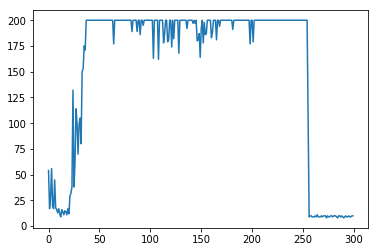

In [213]:
plt.plot(episode_data)

In [268]:
import gym
kick = np.array([0,.001,0,0])
env = gym.make('CartPole-v0')
state = env.reset()
for _ in range(100):
    env.render()
    act = np.argmax(sess.run(AL,feed_dict={X:state.reshape(1,4)}))
    state,reward,done,empty = env.step(env.action_space.sample())
    #state = state + (kick if np.random.binomial(.01,1) == 1 else np.array([0,0,0,0]))
    if done:
        break

In [307]:
env.state()

AttributeError: 'TimeLimit' object has no attribute 'state'

In [189]:
env.seed(25)
state = env.reset()
sess.run(AL,feed_dict={X:state.reshape(1,4)})

array([[23.297506, 22.656996]], dtype=float32)

In [214]:
import gym
kick = np.array([0,.8,0,0])
env = gym.make('CartPole-v0')
env.seed(48)
state = env.reset()
print(state)
for t in range(1000):
    env.render()
    print(sess.run(AL,feed_dict={X:state.reshape(1,4)}))
    action = np.argmax(sess.run(AL,feed_dict={X:state.reshape(1,4)}))
    print(action)
    state,reward,done,empty = env.step(action) # take a random action
    
        
    

You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


[ 0.02879972 -0.00074063  0.00347137  0.00877952]
[[12770.984 12343.326]]
0
[[12983.537 12552.088]]
0
[[12685.125 12297.205]]
0
[[12295.428 11962.425]]
0
[[11858.492 11584.65 ]]
0
[[11368.236 11158.235]]
0
[[10818.589 10677.547]]
0
[[10240.822 10173.846]]
0
[[9623.857 9636.513]]
1
[[9484.379 9490.824]]
1
[[9312.713 9314.469]]
1
[[9109.62  9108.174]]
0
[[8389.55  8473.741]]
1
[[8073.1177 8162.935 ]]
1
[[7714.0894 7812.2705]]
1
[[7313.4097 7422.571 ]]
1
[[6872.7407 6995.2056]]
1
[[6392.607  6530.6685]]
1
[[5864.526  6021.6367]]
1
[[5286.5566 5466.451 ]]
1
[[4672.4673 4869.5547]]
1
[[4039.426 4250.607]]
1
[[3663.6592 3881.1462]]
1
[[3352.893  3571.4326]]
1
[[3019.653  3239.5576]]
1
[[2663.5508 2885.3757]]
1
[[2282.244  2506.0083]]
1
[[1872.8813 2097.938 ]]
1
[[1438.0388 1664.9427]]
1
[[ 976.7343 1206.0884]]
1
[[487.8701 720.3291]]
1
[[-18.387196 218.2562  ]]
1
[[-304.01227  -68.956  ]]
1
[[-417.32736 -221.83838]]
1
[[-461.69528 -284.15234]]
1
[[-501.1163 -334.306 ]]
1
[[-529.9051 -368.030

AttributeError: 'NoneType' object has no attribute 'flip'

In [318]:
np.random.binomial(.9,1)

0

In [263]:
kick = np.array([0,.001,0,0])

In [265]:
kick if np.random.binomial(.01,1) == 1 else np.array([0,0,0,0])

0

In [118]:
test = .01 if False else .02

In [119]:
test

0.02